# Kaggle: San Francisco Crime Classification

Predict the category of crimes that occurred in the city by the bay

From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.

In [1]:
# to add
# probability parameter
# call .decision_function(x) to get probabilities

# normalize your features
# try day of year, day or month, day of week, hour of day...
# polarize features, as done in the M&V 

In [2]:
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cross_validation, preprocessing
from os.path import expanduser, normpath
import time
import datetime

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


In [4]:
# Set paths for data to be imported

home = expanduser('~')
# path = str(home) + '\\Documents\\data-science\\kaggle\\sf-crime\\' # Windows
path = str(home) + '/Documents/Personal/data-science/kaggle/sf-crime/' # Mac
trainfile = 'train.csv'
testfile = 'test.csv'

In [5]:
train_data_raw = pd.read_csv(path+trainfile)
test_data_raw = pd.read_csv(path+testfile)

In [6]:
# train_data.groupby('Category').size().sort_values()

## Features

In [7]:
# train_data_raw['Category'].value_counts()

In [8]:
train_data = train_data_raw.copy()
test_data = test_data_raw.copy()

In [9]:
# Remove unnecessary features
train_data.drop(['Descript', 
                 'Resolution', 
                 'PdDistrict', 
                 'DayOfWeek', 
                 'Address'], inplace=True, axis=1)

test_data.drop(['PdDistrict', 
                'DayOfWeek', 
                'Address'], inplace=True, axis=1)

In [10]:
train_data['Dates'] = pd.to_datetime(train_data['Dates'])
train_data['year'] = train_data['Dates'].dt.year
train_data['month'] = train_data['Dates'].dt.month 
train_data['day'] = train_data['Dates'].dt.day
train_data['hour'] = train_data['Dates'].dt.hour
train_data['minute'] = train_data['Dates'].dt.minute

train_data['dayofyear'] = train_data['Dates'].dt.dayofyear
train_data['dayofweek'] = train_data['Dates'].dt.dayofweek

In [11]:
test_data['Dates'] = pd.to_datetime(test_data['Dates'])
test_data['year'] = test_data['Dates'].dt.year
test_data['month'] = test_data['Dates'].dt.month 
test_data['day'] = test_data['Dates'].dt.day
test_data['hour'] = test_data['Dates'].dt.hour
test_data['minute'] = test_data['Dates'].dt.minute

test_data['dayofyear'] = test_data['Dates'].dt.dayofyear
test_data['dayofweek'] = test_data['Dates'].dt.dayofweek

In [12]:
# Set up 0 to 1 scaler for preprocessing features in training and test sets
min_max_scaler = preprocessing.MinMaxScaler()

In [13]:
train_data_noscale = pd.DataFrame(train_data[['Category','Dates']])
train_data.drop(['Category', 'Dates'], inplace=True, axis=1)

In [14]:
train_data_minmax = pd.DataFrame(min_max_scaler.fit_transform(train_data),
                                 index = train_data.index, 
                                 columns = train_data.columns) 
train_data_minmax[['Category','Dates']] = train_data_noscale

In [15]:
test_data_noscale= pd.DataFrame(test_data[['Id','Dates']])
test_data.drop(['Id', 'Dates'], inplace=True, axis=1)

In [16]:
test_data_minmax = pd.DataFrame(min_max_scaler.transform(test_data),
                                index = test_data.index, 
                                columns = test_data.columns) 
test_data_minmax[['Id','Dates']] = test_data_noscale

In [17]:
# Decide which features to go into training set
X_train = train_data_minmax.ix[:,['dayofyear','dayofweek','hour','X','Y']]
y_train = train_data_minmax.ix[:,'Category']

In [ ]:
# generate training and cross-validation features
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_train, 
                                                                 y_train, 
                                                                 test_size=0, 
                                                                 random_state=1)

In [18]:
X_test = test_data_minmax.ix[:,['dayofyear','dayofweek','hour','X','Y']]

In [ ]:
# # polarize data
#     if tod:
#         times = index.hour
#         tody = np.cos(2*np.pi*times/24)
#         todx = np.sin(2*np.pi*times/24)     
        
#         X_train[:,2] = tody[shuffling][:n_points]
#         X_train[:,3] = todx[shuffling][:n_points]
        
#         X_test[:,2] = tody[shuffling][n_points:]
#         X_test[:,3] = todx[shuffling][n_points:]

## Random Forest Model

In [19]:
crime_forest = RandomForestClassifier()

In [20]:
%time crime_forest = crime_forest.fit(X_train, y_train)

CPU times: user 31 s, sys: 1.58 s, total: 32.6 s
Wall time: 33.7 s


In [ ]:
%%time

score_train = crime_forest.score(X_train, y_train)
score_cv = crime_forest.score(X_cv, y_cv)

# test/train
# 20/80 split Training Score: 0.944199898638 , CV Score: 0.217073344343
# 50/50 split Training Score: 0.894782517584 , CV Score: 0.242728773988
# 80/20 split Training Score: 0.943824063687 , CV Score: 0.219235806617
print ('Training Score:', score_train, ', CV Score:', score_cv) 

In [24]:
crime_forest.feature_importances_

array([ 0.34517333,  0.10516017,  0.11450594,  0.21685496,  0.2183056 ])

In [25]:
prob_prediction = crime_forest.predict_proba(X_test)

In [47]:
submission = pd.DataFrame(prob_prediction, index=X_test.index, columns=crime_forest.classes_)

In [48]:
submission.to_csv('submission_2016_03_06.csv')

### Plotting learning curves

In [20]:
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


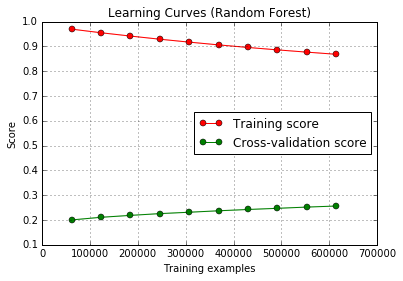

CPU times: user 22.6 s, sys: 10.9 s, total: 33.4 s
Wall time: 37min 51s


In [21]:
%%time 
X, y = X_train, y_train
train_data = X
estimator = crime_forest

# from sklearn.ensemble import GradientBoostingClassifier
# estimator = GradientBoostingClassifier()
title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(train_data.shape[0], n_iter=20,
                                   test_size=0.3, random_state=0)

plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)
plt.show()

## SVM Model

### Exhaustive Grid Search

In [ ]:
# Split again, generate training and cross-validation features for grid search
X_grid_train, X_grid_cv, y_grid_train, y_grid_cv = cross_validation.train_test_split(X_train, 
                                                                 y_train, 
                                                                 test_size=0.50, 
                                                                 random_state=1)

In [ ]:
param_grid = [
    {'estimator__C': [100, 1000, 10000], 'estimator__gamma': [0.01, 0.001, 0.0001], 'estimator__kernel': ['rbf']}
]
scores = ['precision', 'recall']

In [ ]:
%%time
clf = GridSearchCV(OneVsRestClassifier(SVC()), param_grid, error_score=0)
clf.fit(X_grid_train, y_grid_train)

print(clf.best_score_, clf.best_params_)

In [ ]:
# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(OneVsRestClassifier(SVC()), param_grid,
#                        scoring='%s_weighted' % score)
#     clf.fit(X_grid_train, y_grid_train)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     for params, mean_score, scores in clf.grid_scores_:
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean_score, scores.std() * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_grid_cv, clf.predict(X_grid_cv)
#     print(classification_report(y_true, y_pred))
#     print()

In [ ]:
# Run for 5% of sample set, ~1.5 hour run time
# # Tuning hyper-parameters for precision

# {'estimator__C': 1000, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.001}

# Grid scores on development set:

# 0.140 (+/-0.162) for {'estimator__C': 1, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.001}
# 0.093 (+/-0.168) for {'estimator__C': 1, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.0001}
# 0.137 (+/-0.194) for {'estimator__C': 10, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.001}
# 0.091 (+/-0.159) for {'estimator__C': 10, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.0001}
# 0.134 (+/-0.116) for {'estimator__C': 100, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.001}
# 0.091 (+/-0.160) for {'estimator__C': 100, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.0001}
# 0.154 (+/-0.123) for {'estimator__C': 1000, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.001}
# 0.131 (+/-0.186) for {'estimator__C': 1000, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.0001}

# Detailed classification report:

# The model is trained on the full development set.
# The scores are computed on the full evaluation set.

#              precision    recall  f1-score   support

#       ARSON       0.00      0.00      0.00        87
#     ASSAULT       0.00      0.00      0.00      3827
#  BAD CHECKS       0.00      0.00      0.00        19
#     BRIBERY       0.00      0.00      0.00        13
#    BURGLARY       0.00      0.00      0.00      1877
# DISORDERLY CONDUCT       0.00      0.00      0.00       219
# DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       121
# DRUG/NARCOTIC       0.00      0.00      0.00      2789
# DRUNKENNESS       0.00      0.00      0.00       222
# EMBEZZLEMENT       0.00      0.00      0.00        59
#   EXTORTION       0.00      0.18      0.00        11
# FAMILY OFFENSES       0.00      0.09      0.00        23
# FORGERY/COUNTERFEITING       0.00      0.00      0.00       545
#       FRAUD       0.00      0.00      0.00       846
#    GAMBLING       0.00      0.00      0.00        11
#  KIDNAPPING       0.00      0.00      0.00       118
# LARCENY/THEFT       0.33      0.00      0.00      8772
# LIQUOR LAWS       0.00      0.00      0.00        87
#   LOITERING       0.00      0.00      0.00        62
# MISSING PERSON       0.00      0.00      0.00      1372
# NON-CRIMINAL       0.00      0.00      0.00      4541
# OTHER OFFENSES       0.00      0.00      0.00      6345
# PORNOGRAPHY/OBSCENE MAT       0.00      1.00      0.00         2
# PROSTITUTION       0.00      0.00      0.00       361
# RECOVERED VEHICLE       0.00      0.00      0.00       138
#     ROBBERY       0.00      0.00      0.00      1151
#     RUNAWAY       0.00      0.00      0.00       102
# SECONDARY CODES       0.00      0.00      0.00       485
# SEX OFFENSES FORCIBLE       0.00      0.00      0.00       199
# SEX OFFENSES NON FORCIBLE       0.00      0.00      0.00        10
# STOLEN PROPERTY       0.00      0.00      0.00       225
#     SUICIDE       0.00      0.00      0.00        26
# SUSPICIOUS OCC       0.00      0.00      0.00      1512
#        TREA       0.00      0.00      0.00         0
#    TRESPASS       0.00      0.00      0.00       344
#   VANDALISM       0.00      0.00      0.00      2204
# VEHICLE THEFT       0.00      0.00      0.00      2625
#    WARRANTS       0.00      0.00      0.00      2148
# WEAPON LAWS       0.00      0.00      0.00       404

# avg / total       0.07      0.00      0.00     43902

# # Tuning hyper-parameters for recall

# {'estimator__C': 10, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.0001}

# Grid scores on development set:

# 0.006 (+/-0.005) for {'estimator__C': 1, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.001}
# 0.030 (+/-0.036) for {'estimator__C': 1, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.0001}
# 0.002 (+/-0.001) for {'estimator__C': 10, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.001}
# 0.033 (+/-0.006) for {'estimator__C': 10, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.0001}
# 0.013 (+/-0.028) for {'estimator__C': 100, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.001}
# 0.007 (+/-0.006) for {'estimator__C': 100, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.0001}
# 0.002 (+/-0.005) for {'estimator__C': 1000, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.001}
# 0.000 (+/-0.000) for {'estimator__C': 1000, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.0001}

# Detailed classification report:

# The model is trained on the full development set.
# The scores are computed on the full evaluation set.

#              precision    recall  f1-score   support

#       ARSON       0.00      0.00      0.00        87
#     ASSAULT       0.00      0.00      0.00      3827
#  BAD CHECKS       0.00      0.00      0.00        19
#     BRIBERY       0.00      0.00      0.00        13
#    BURGLARY       0.00      0.00      0.00      1877
# DISORDERLY CONDUCT       0.02      0.02      0.02       219
# DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       121
# DRUG/NARCOTIC       0.00      0.00      0.00      2789
# DRUNKENNESS       0.00      0.00      0.00       222
# EMBEZZLEMENT       0.00      0.00      0.00        59
#   EXTORTION       0.00      0.00      0.00        11
# FAMILY OFFENSES       0.00      0.00      0.00        23
# FORGERY/COUNTERFEITING       0.00      0.00      0.00       545
#       FRAUD       0.00      0.00      0.00       846
#    GAMBLING       0.00      0.00      0.00        11
#  KIDNAPPING       0.00      0.00      0.00       118
# LARCENY/THEFT       0.33      0.00      0.00      8772
# LIQUOR LAWS       0.00      0.00      0.00        87
#   LOITERING       0.00      0.00      0.00        62
# MISSING PERSON       0.00      0.00      0.00      1372
# NON-CRIMINAL       0.00      0.00      0.00      4541
# OTHER OFFENSES       0.00      0.00      0.00      6345
# PORNOGRAPHY/OBSCENE MAT       0.00      0.00      0.00         2
# PROSTITUTION       0.00      0.00      0.00       361
# RECOVERED VEHICLE       0.00      0.00      0.00       138
#     ROBBERY       0.00      0.00      0.00      1151
#     RUNAWAY       0.00      0.00      0.00       102
# SECONDARY CODES       0.00      0.00      0.00       485
# SEX OFFENSES FORCIBLE       0.00      0.00      0.00       199
# SEX OFFENSES NON FORCIBLE       0.00      0.00      0.00        10
# STOLEN PROPERTY       0.00      0.00      0.00       225
#     SUICIDE       0.00      0.00      0.00        26
# SUSPICIOUS OCC       0.03      0.29      0.06      1512
#    TRESPASS       0.00      0.00      0.00       344
#   VANDALISM       0.05      0.33      0.09      2204
# VEHICLE THEFT       0.00      0.00      0.00      2625
#    WARRANTS       0.00      0.00      0.00      2148
# WEAPON LAWS       0.01      0.39      0.02       404

# avg / total       0.07      0.03      0.01     43902

In [ ]:
# 0.00470365814769 {'estimator__C': 100, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
# CPU times: user 8h 4min 31s, sys: 7min 20s, total: 8h 11min 52s
# Wall time: 10h 11s
    
# LARCENY/THEFT                  17471
# OTHER OFFENSES                 12703
# NON-CRIMINAL                    9163
# ASSAULT                         7628
# DRUG/NARCOTIC                   5428
# VEHICLE THEFT                   5307
# VANDALISM                       4509
# WARRANTS                        4194
# BURGLARY                        3650
# SUSPICIOUS OCC                  3156
# MISSING PERSON                  2690
# ROBBERY                         2233
# FRAUD                           1686
# FORGERY/COUNTERFEITING          1082
# SECONDARY CODES                 1005
# WEAPON LAWS                      804
# TRESPASS                         771
# PROSTITUTION                     761
# STOLEN PROPERTY                  467
# DISORDERLY CONDUCT               426
# DRUNKENNESS                      416
# SEX OFFENSES FORCIBLE            413
# RECOVERED VEHICLE                304
# KIDNAPPING                       239
# DRIVING UNDER THE INFLUENCE      235
# RUNAWAY                          215
# LIQUOR LAWS                      197
# ARSON                            152
# EMBEZZLEMENT                     129
# LOITERING                        125
# SUICIDE                           52
# FAMILY OFFENSES                   50
# BAD CHECKS                        40
# BRIBERY                           38
# EXTORTION                         22
# GAMBLING                          18
# SEX OFFENSES NON FORCIBLE         16
# PORNOGRAPHY/OBSCENE MAT            7
# TREA                               2

In [ ]:
# # Run on 10% of trainining with another 10% for validation

# Grid search results

# 0.00470365814769 {'estimator__C': 100, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
# CPU times: user 8h 4min 31s, sys: 7min 20s, total: 8h 11min 52s
# Wall time: 10h 11s

### SVC Model prediction

In [ ]:
%%time

# SUPPORT VECTOR MACHINE

crime_svm = OneVsRestClassifier(SVC(C = 100, gamma = 0.01, kernel='rbf'))
crime_svm.fit(X_train, y_train)

In [ ]:
%%time

score_train = crime_svm.score(X_train, y_train)
score_cv = crime_svm.score(X_cv, y_cv)


print ('Training Score:', score_train, ', CV Score:', score_cv) # Score:  0.0880649625019 , Time:  0.27322959899902344

In [ ]:
%time output = crime_svm.predict(X_test)

In [ ]:
pd.get_dummies(output)

In [ ]:
cat_uniques = train_data_raw.Category.unique()

In [ ]:
headers = 'Id,' + ','.join(sorted(cat_uniques)) + '\n'
f = open('y_test.csv', 'w')
f.write(headers)
for i in xrange(len(y_test)):
    arr = [0] * 39
    arr[int(y_test)]